# P0: Intro

<center><b>Machine Learning Project</b></center>
<br><center><b>Sharif University of Technology - Fall 2023</b></center>

<div style="text-align:justify">Hopefully, the course has been insightful for you till now. This notebook serves as a template for the project which involves training a sentiment analyzer neural network using the comments of a Persian website and fine-tuning it using the comments of another.<br><br>
The first website is Snappfood which is used by the people in Iran to order different kinds of food. The latter is Digikala, an online store for Iranians where people buy many things including smartphones, groceries, cars, and whatever you consider legal. Both websites provide users with ways to express their opinions about the products.<br><br>
A domain shift may be revealed to some degree when switching from Snappfood comments to the ones extracted from Digikala. This will be one of the challenges you will be faced with. So, beware of it!</div>

# P1: Exploring the Datasets (25 points)

Both of the datasets are added to the notebook. In this part, we want to explore their contents. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Load both of the datasets 

In [4]:
snappdf = pd.read_csv('SnappfoodData.csv', on_bad_lines='skip' , delimiter='\t')
digidf = pd.read_csv('DigikalaData.csv')

In [7]:
snappdf.head()
digidf.head()

,Text,Score,Suggestion
0,این اولین تجربه من برای خرید ایفون هست امروز...,100,1
1,خرید این محصول رو توصیه میکنم,84,1
2,1 ساله این گوشی رو دارم هیچ نقطه ضعفی ازش ند...,60,1
3,سلام خدمت دوستان این گوشی از همه نظر عالی کیف...,96,1
4,سلام دوستانی که نگران شکستن صفحه نمایش هستند ا...,92,1


Count the number of comments each dataset contains **(P1-1: 5 points)**

In [8]:
# remove Unnamed: 0 column
snappdf.drop('Unnamed: 0', axis=1, inplace=True)
snappdf.head()

,comment,label,label_id
0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,SAD,1.0
1,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,HAPPY,0.0
2,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,SAD,1.0
3,عالللی بود همه چه درست و به اندازه و کیفیت خوب...,HAPPY,0.0
4,شیرینی وانیلی فقط یک مدل بود.,HAPPY,0.0


In [9]:
# remove nan values
snappdf.dropna(inplace=True)
digidf.dropna(inplace=True)

In [10]:
# count number of comments in each dataset
print('Number of comments in Snappfood dataset: ', len(snappdf))
print('Number of comments in Digikala dataset: ', len(digidf))

Number of comments in Snappfood dataset:  69480
Number of comments in Digikala dataset:  3261


Represent the distribution of comments in the Snappfood dataset in terms of being negative or positive **(P1-2: 5 points)**

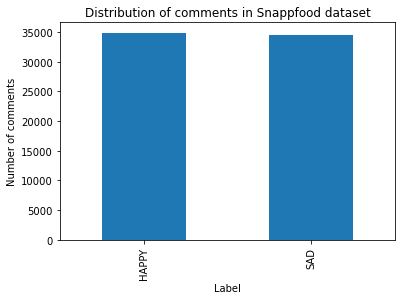

HAPPY    34916
SAD      34564
Name: label, dtype: int64


In [12]:
# represent distribution of comments in snappdf based on label
snappdf['label'].value_counts().plot(kind='bar')
plt.title('Distribution of comments in Snappfood dataset')
plt.xlabel('Label')
plt.ylabel('Number of comments')
plt.show()
print(snappdf['label'].value_counts())

Plot the logarithm of the frequency of words as a function of the logarithm of their rank to demonstrate the Zipf's law. <br>
Note: Don't panic! The Zipf's law can be found here: https://nlp.stanford.edu/IR-book/html/htmledition/zipfs-law-modeling-the-distribution-of-terms-1.html and can be easily understood. **(P1-3: 5 points)**

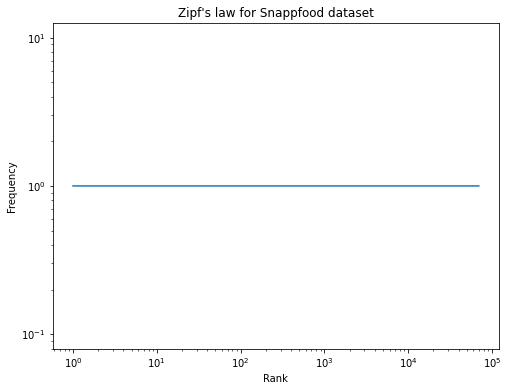

In [13]:
#Plot the logarithm of the frequency of words as a function of the logarithm of their rank to demonstrate the Zipf's law.
from collections import Counter
import math
import matplotlib.pyplot as plt
import seaborn as sns

def plot_zipf_law(data, title):
    counts = Counter(data)
    tokens = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    ranks = range(1, len(counts) + 1)
    frequencies = [count for _, count in tokens]
    plt.figure(figsize=(8, 6))
    plt.plot(ranks, frequencies)
    plt.xlabel('Rank')
    plt.ylabel('Frequency')
    plt.xscale('log')
    plt.yscale('log')
    plt.title(title)
    plt.show()

plot_zipf_law(snappdf['comment'], 'Zipf\'s law for Snappfood dataset')

Add a new column to the Digikala dataset indicating whether the comment was positive, negative, or neutral. This will be needed later for classification. <br>
Note: This can be done in many ways. You should the appropriate method. **(P1-4: 5 points)**

In [22]:
digidf['label'] = digidf['Score'].apply(lambda x: 'positive' if x > 66 else ('neutral' if x > 33 else 'negative'))
digidf.head()

,Text,Score,Suggestion,label
0,این اولین تجربه من برای خرید ایفون هست امروز...,100,1,positive
1,خرید این محصول رو توصیه میکنم,84,1,positive
2,1 ساله این گوشی رو دارم هیچ نقطه ضعفی ازش ند...,60,1,neutral
3,سلام خدمت دوستان این گوشی از همه نظر عالی کیف...,96,1,positive
4,سلام دوستانی که نگران شکستن صفحه نمایش هستند ا...,92,1,positive


Split each dataset into training, testing, and validation sets. **(P1-5: 5 points)**

In [23]:

from sklearn.model_selection import train_test_split
digi_train, digi_test = train_test_split(digidf, test_size=0.2, random_state=42)
digi_val, digi_test = train_test_split(digi_test, test_size=0.5, random_state=42)

snapp_train, snapp_test = train_test_split(snappdf, test_size=0.2, random_state=42)
snapp_val, snapp_test = train_test_split(snapp_test, test_size=0.5, random_state=42)

# P2: Preprocessing and Feature Extraction (20 points)

The goal of this part is to make the Snappfood dataset ready for the neural network to be trained with.<br>
Note: You can use many libraries including `NLTK`, `Spacy`, `Hazm`, `Parsivar`, `Stanza` etc.

Remove the unnecessary characters of the dataset. <br>
**(P2-1: 5 points)**

Normalize the dataset. <br>
Note: Check the result. For instance, if you do this correctly, you'll have a dataset containing just 1 type of space. **(P2-2: 5 points)**

If you want to include other preprocessing steps, put all of your code here.

Extract features from the Snappfood dataset
<br> Note: You should use both of the following methods, and compare the results at the end.
- Method 1 (Classic): Use `CountVectorizer` or `TF-IDF`.
- Method 2 (Modern): Use `Word2Vec`, `FastText`, `GloVe`, `Doc2Vec` or train your own `Embedding` Layer. 

If you choose to train your own `Embedding`s, you'll just need to specify an ID for each word remaining in your dataset. **(P2-3: 10 points)**

# P3: Training and Initial Evaluation (20 points)

Define an architecture for your neural network. **(P3-1: 5 points)**

Train the network on the Snappfood dataset, while monitoring its performance on the validation set. **(P3-2: 5 points)**

Evaluate the performance of your network on the Snappfood testing set. **(P3-3: 5 points)**

Save the weights of the neural network and its architecture seperately in the notebook's output folder (`/kaggle/working/`). **(P3-4: 5 points)**

# P4: Fine-tuning and Evaluation (35 points)

In this part, we will fine-tune the previously trained network on the comments extracted from Digikala.

Load the neural network along with its weights **(P4-1: 5 points)**

Change the architecture of the network (the last layer) to make it appropriate for classifying the sentiment of a comment in one of the previously mentioned three classes: positive, negative, or neutral. **(P4-2: 5 points)**

Extract features from the Digikala dataset.<br>
Note: Pay attention to the fact that your features are the same as the ones you extracted from the Snappfood dataset. You just need to use the same method for the new dataset. For instance, if you consider the `CountVectorizer` as your feature extractor, the set of the words for which you'll count the frequency will not change! **(P4-3: 15 points)**

Fine-tune the network on the training set associated with the Digikala dataset, while monitoring its performance on the corresponding validation set.<br>
Note: The process of fine-tuning should follow one of these methods:
- Method 1: Fix the weights for all layers expect the last one.
- Method 2: Use a really small learning rate for all layers except the last one.

**(P4-4: 5 points)**

Evaluate the performance of the neural network on the testing set you have extracted from the Digikala dataset. **(P4-5: 5 points)**